In [1]:
import numpy as np

import sys
sys.path.append("/home/tintin/rongheng/cv/")
from lib.image_lib import show_img, load_img
import lib.edge_lib as edge

from scipy.ndimage import morphology as morph_n, affine_transform

from skimage.filters import sobel
import skimage.feature as feature
import skimage.morphology as morph
from skimage import transform as tf

from scipy import ndimage as nd

import matplotlib.pyplot as plt
from matplotlib import cm 

from skimage.transform import hough_line, hough_line_peaks

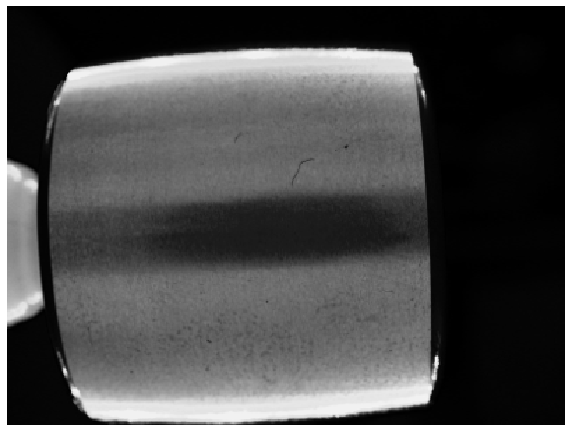

In [2]:
img = load_img('d01.jpg', size=(400, 400))
show_img(img, color='bw')

300 400 120000


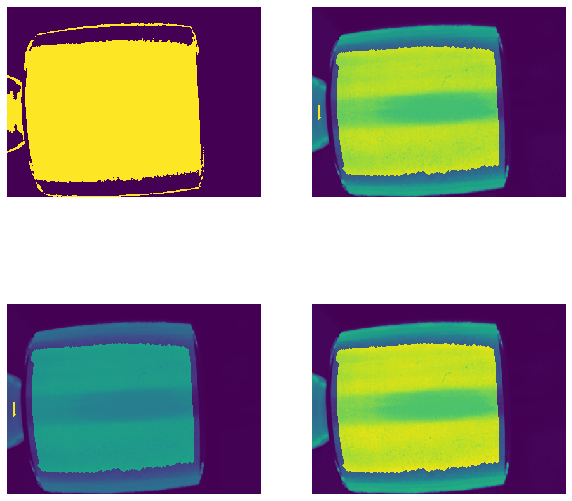

In [3]:
h, w = img.shape
size = h*w
print(h,w, h*w)

markers = np.zeros_like(img)
markers[img > 255*0.05] = 1
markers[img > 255*0.6] = 0

erosion = morph_n.binary_erosion(markers, iterations=10)

labled, _ = nd.label(erosion)

bearing = morph.remove_small_objects(labled, size*0.2)

show_img(markers, img+erosion*255, img+labled*255, img+ bearing*255)

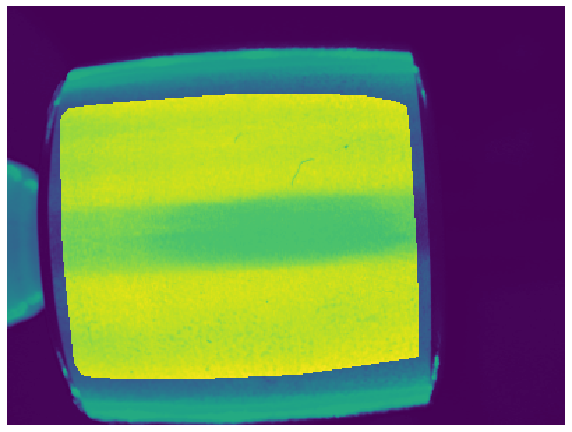

In [4]:
mask = morph.convex_hull_image(bearing)
show_img(img+mask*255)

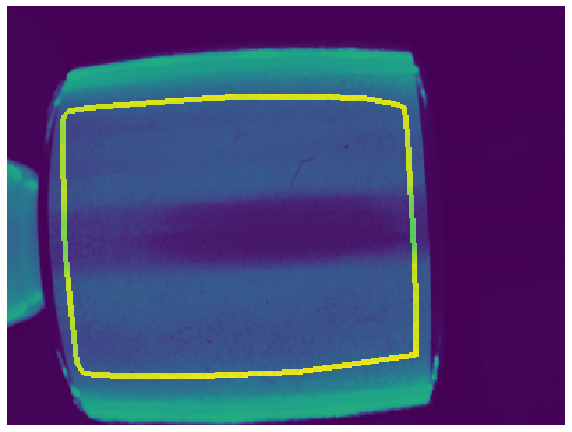

In [5]:
inside = morph_n.binary_erosion(mask, iterations=4)
border = mask.astype(int) - inside.astype(int)
show_img(img+border*255)

(90.0, -90.0, 500.0, -500.0)

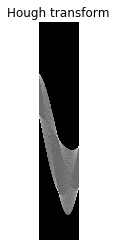

In [6]:
h, theta, d = hough_line(border)

fig, ax = plt.subplots()
plt.imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray)
ax.set_title('Hough transform')
ax.set_xlabel('Angles (degrees)')
ax.set_ylabel('Distance (pixels)')
ax.axis('off')

(300, 400)


Text(0.5, 1.0, 'Detected lines')

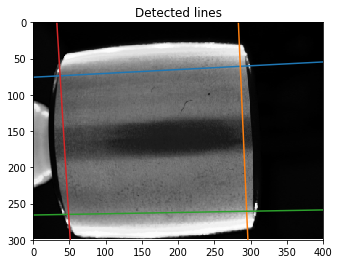

In [7]:
fig, ax = plt.subplots()
ax.imshow(img, cmap=cm.gray)

height, width = img.shape
print(img.shape)

hough_lines = zip(*hough_line_peaks(h, theta, d))

def line(agnle, dist):
    global width
    line_equation = lambda x: (dist - x * np.cos(angle))/np.sin(angle)
    p1, p2 = [(x, line_equation(x)) for x in np.linspace(0, width, 2)]
    
    return p1, p2
    
lines = []
for _, angle, dist in hough_lines:
    l = line(angle, dist)
    lines.append(l)
    
for p1, p2 in lines:
    x, y = zip(p1, p2)
    ax.plot(x, y, "-")
    
ax.set_xlim((0, width))
ax.set_ylim((height, 0))
ax.set_title('Detected lines')

In [8]:
def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersect(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        if 0 < x <= width and 0 < y <= height:
            return x,y
    else:
        return False

Corner 0:
x: 285.72    y: 60.62

Corner 1:
x: 37.13    y: 73.72

Corner 2:
x: 294.50    y: 260.64

Corner 3:
x: 48.89    y: 264.95



Text(0.5, 1.0, 'Corners')

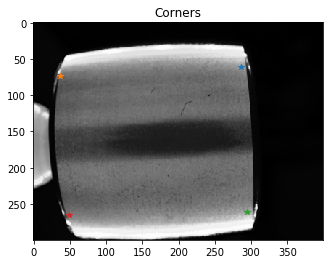

In [9]:
import itertools as it

lines_permut = list(it.combinations(lines,2))
intersections = []

for l1, l2 in lines_permut:
    #print("Line 1: ", l1)
    #print("Line 2:", l2)
    L1 = line(*l1)
    L2 = line(*l2)
    r = intersect(L1, L2)
    if r:
        intersections.append(r)
        
fig, ax = plt.subplots()
ax.imshow(img, cmap=cm.gray)

for i, intersection in enumerate(intersections):
    x, y = intersection
    ax.plot(x, y, "*")
    print("Corner", str(i)+":")
    print("x: {:.2f}    y: {:.02f}\n".format(x, y))
    
ax.set_title('Corners')

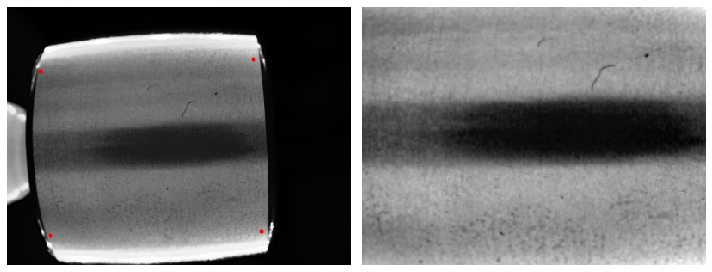

In [10]:
top_left, bottom_left, top_right, bottom_right = sorted(intersections)

src = np.array([[0, 0], [0, height], [width, height], [width, 0]])
dst = np.array([top_left, bottom_left, bottom_right, top_right])

tform3 = tf.ProjectiveTransform()
tform3.estimate(src, dst)
warped = tf.warp(img, tform3, output_shape=(300, 400))

fig, ax = plt.subplots(ncols=2, figsize=(10,20))

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].plot(dst[:, 0], dst[:, 1], '.r')
ax[1].imshow(warped, cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

plt.tight_layout()

plt.show()